## Clustering

Clustering is an unsupervised learning approach used to group similar data points together based on their inherent characteristics. The goal is to identify patterns and structures in the dataset without prior knowledge of the labels. In this project, we hope to use clustering to discover meaningful subgroups within the patient population, which could help in understanding differences in treatment responses or outcomes, and potentially reveal patient phenotypes that benefit from specific interventions.


Table of contents
- 0. Prepare the Jupyter Notebook
- 1. Standardization or Normalization
- 2. Kmeans clustering

### 0. Preparing the Jupyter Notebook

To begin, we load the necessary libraries and import the prepared dataset. We will use **`patient_data_onehot_imputed`** as it already includes all preprocessing steps required for machine learning, except for **normalization or standardization**. This ensures we have a consistent and clean dataset ready for further analysis.


In [1]:
# Set the flag for different approaches
exclude_no_ttm = True # If you change this, check the optimal number of clusters and the results...

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


In [3]:
# Loading the dataset
with open('data/patient_data_onehot_imputed.pkl', 'rb') as file:
    processed_data = pickle.load(file)

processed_data.head()

,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,284,53.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,286,85.0,7.0,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,296,48.0,18.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,299,45.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,303,51.0,24.0,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False


In [4]:
# Loading the original dataset for later comparison of clusters
with open('data/patient_data.pkl', 'rb') as file:
    original_data = pickle.load(file)
    
original_data.head()

,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,284,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0
1,286,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0
2,296,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0
3,299,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0
4,303,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0


### 1. Standardization or Normalization

Next, we determine whether **standardization** or **normalization** is appropriate for our dataset to ensure consistent feature scaling. To make an informed decision, we first visualize the distribution of the numerical features. Based on these distributions, we then apply the selected scaling technique to align the data for better performance in machine learning models.


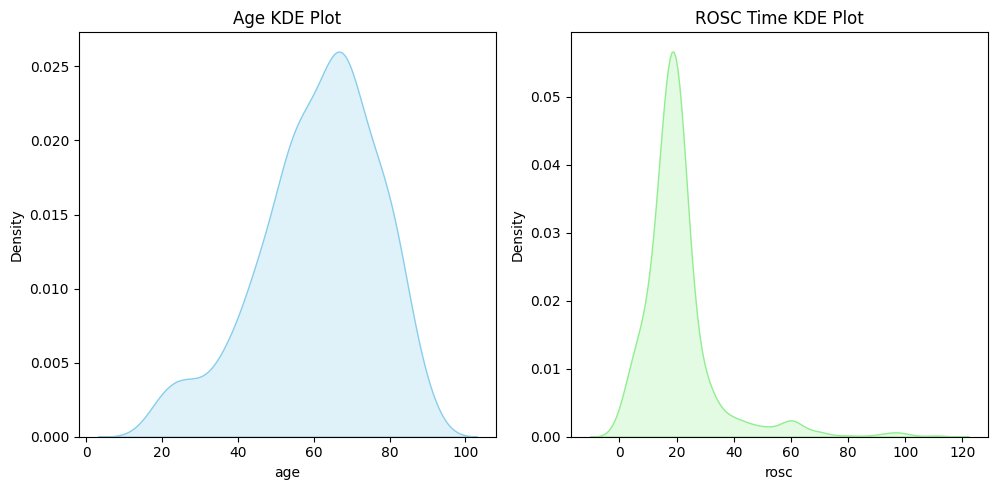

In [5]:
# Plotting count plot for CPC instead of KDE plot
plt.figure(figsize=(15, 5))

# Age KDE Plot
plt.subplot(1, 3, 1)
sns.kdeplot(processed_data['age'], fill=True, color='skyblue')
plt.title('Age KDE Plot')

# ROSC KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(processed_data['rosc'], fill=True, color='lightgreen')
plt.title('ROSC Time KDE Plot')

plt.tight_layout()
plt.show()


In [6]:
# Display all unique ROSC times from the dataset
unique_rosc_times = processed_data['rosc'].unique()
unique_rosc_times_sorted = np.sort(unique_rosc_times)

# Print the unique ROSC times in sorted order
print(unique_rosc_times_sorted)

[  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
  13.   14.   15.   16.   17.   18.   19.   20.   21.   21.5  22.   24.
  25.   26.   27.   29.   30.   32.   33.   34.   35.   36.   37.   38.
  40.   42.   44.   45.   47.   50.   52.   54.   55.   60.   62.   63.
  67.   70.   80.   90.   95.   96.   98.  100.  111. ]


**Analysis**: The **age** distribution is approximately **normal**, with a slight skew towards lower values and a peak just below **70**. The **ROSC** distribution also appears roughly **normal**, but contains several significant **outliers** that need to be addressed before proceeding with further analysis. Eventhough **ROSC** appears to have negative values, it actually does not.

In [7]:
# Apply Box-Cox transformation to ROSC time
rosc_transformed_boxcox, lambda_value = boxcox(processed_data['rosc'])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_boxcox'] = rosc_transformed_boxcox

In [8]:
# Apply Yeo-Johnson transformation to ROSC time
power_transformer = PowerTransformer(method='yeo-johnson')
rosc_transformed = power_transformer.fit_transform(processed_data[['rosc']])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_yeojohnson'] = rosc_transformed

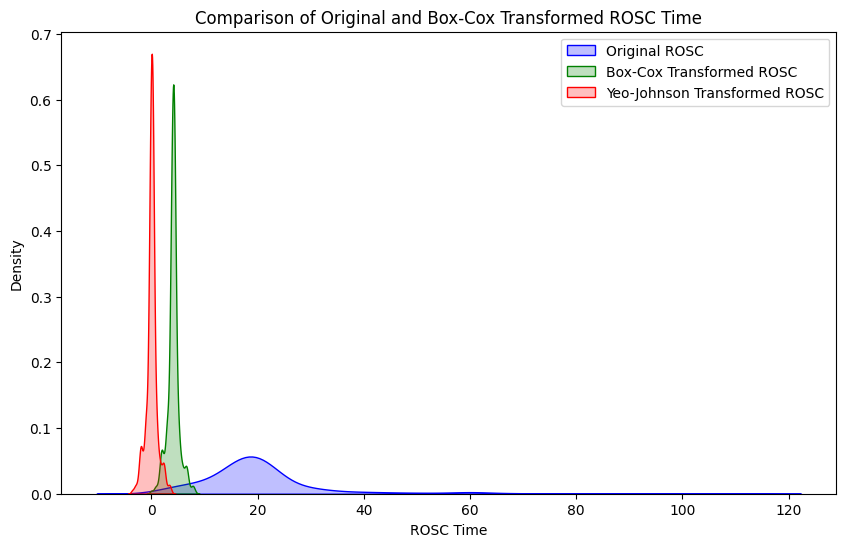

In [9]:
# Plotting original ROSC and Box-Cox transformed ROSC to compare
plt.figure(figsize=(10, 6))

# Original ROSC KDE Plot
sns.kdeplot(processed_data['rosc'], fill=True, color='blue', label='Original ROSC')

# Box-Cox Transformed ROSC KDE Plot
sns.kdeplot(processed_data['rosc_boxcox'], fill=True, color='green', label='Box-Cox Transformed ROSC')

# Apply Yeo-Johnson transformation to ROSC time
sns.kdeplot(processed_data['rosc_yeojohnson'], fill=True, color='red', label='Yeo-Johnson Transformed ROSC')

plt.title('Comparison of Original and Box-Cox Transformed ROSC Time')
plt.xlabel('ROSC Time')
plt.ylabel('Density')
plt.legend()
plt.show()


**Analysis**: Both the **Box-Cox** and **Yeo-Johnson** transformations effectively narrow the distribution, reducing the impact of high outliers. However, the **Box-Cox transformation** retains a slightly broader spread compared to **Yeo-Johnson**, making it preferable for preserving more variability in the data. Therefore, we will proceed with the **Box-Cox transformation**.

#### Standardization
After applying the **Box-Cox transformation** to handle skewness and reduce the influence of outliers, we proceed with **standardization**. Standardization rescales the features so that they have a mean of **0** and a standard deviation of **1**, which is particularly useful for models that assume normally distributed input data or are sensitive to feature scales.

By standardizing the data, we ensure that all features are on a comparable scale, which helps improve model performance and convergence during training.


In [10]:
# Instantiate the scaler
scaler = StandardScaler()

# Columns to standardize
columns_to_standardize = ['age', 'rosc', 'rosc_boxcox', 'rosc_yeojohnson']

# Apply standardization
processed_data[columns_to_standardize] = scaler.fit_transform(processed_data[columns_to_standardize])

# Display the standardized DataFrame
processed_data.head()

,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,...,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc_boxcox,rosc_yeojohnson
0,284,-0.522787,-0.215362,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
1,286,1.525272,-1.023892,False,False,False,False,True,True,False,...,False,False,False,False,True,True,False,False,-1.510616,-1.537350
2,296,-0.842797,-0.215362,True,False,False,False,False,False,True,...,True,False,False,True,False,False,True,False,-0.039577,-0.034742
3,299,-1.034802,-0.215362,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
4,303,-0.650791,0.225655,False,False,True,False,False,False,True,...,True,False,True,False,False,False,True,False,0.471501,0.482048


#### Selecting Data for the Machine Learning Component from the Original DataFrame

We are now selecting the relevant features, including the transformed `rosc` data, from the original DataFrame. This subset will be placed into a new DataFrame, `machine_learning_df`, for clearer separation and easier manipulation during model training. We can experiment with the included features as needed to optimize model performance.

Based on the findings in **02_Feature_Importance**, we concluded that hospital identifiers are not relevant for our model. This aligns with the medical perspective, as our focus should remain on patient-related features. For now, we will retain the other features and proceed with the Box-Cox transformed `rosc`.

In [11]:
# Selecting the desired columns
selected_columns = ['Patient', 'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown', 
                    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 
                    'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 
                    'rosc', 'rosc_boxcox','rosc_yeojohnson']

# Creating a new DataFrame with only the selected columns
machine_learning_df = processed_data[selected_columns]

if exclude_no_ttm:
    # Try to exclude No_TTM as we are interested in TTM
    machine_learning_df = machine_learning_df[machine_learning_df['ttm_No TTM'] == 0]
    machine_learning_df = machine_learning_df.drop(columns=['ttm_No TTM'])
    original_data = original_data[original_data['ttm'].isin([33.0, 36.0])]


# Set up the df dictionary to compare the different scalers
dataframes_clustering = {
    "rosc": machine_learning_df.drop(columns=['rosc_boxcox', 'rosc_yeojohnson', 'Patient']),
    "rosc_boxcox": machine_learning_df.drop(columns=['rosc', 'rosc_yeojohnson', 'Patient']),
    "rosc_yeojohnson": machine_learning_df.drop(columns=['rosc', 'rosc_boxcox', 'Patient'])
}

### 2. KMeans Clustering
**KMeans Clustering** is an unsupervised machine learning algorithm that groups data points into a specified number of clusters (k) based on feature similarity. The algorithm assigns each data point to the nearest cluster centroid, iteratively updating the centroids until the optimal clustering configuration is reached.

In this project, we use KMeans clustering to uncover potential patterns or natural groupings within the data. By analyzing these clusters, we hope to gain insights into distinct patient subgroups that may share similar characteristics, which could be valuable for tailoring treatment approaches or identifying risk profiles.

#### 2.1 Silhouette Scores

We use **Silhouette Scores** to determine the optimal number of clusters for the `machine_learning_patient_data`. This method evaluates how well each data point fits within its assigned cluster compared to other clusters, providing a measure of clustering quality. Higher silhouette scores indicate that data points are well-matched within their clusters and distinct from others, which helps us assess the "purity" of each cluster.

The algorithm iterates through various cluster counts, calculating the silhouette score for each, allowing us to identify the number of clusters that best separates the data into meaningful groups.

**Usually, there should be only about 10-15% clusters compared to the data size.** Choosing too large a number of clusters can cause overfitting and may even capture noise rather than meaningful patterns. Additionally, for clinical practice, selecting a low number of clusters that remain interpretable is ideal, which typically means fewer than 20 clusters. However, we will run from 2 to 50 clusters and try to focus on a local maximum under 20 clusters.

Calculating silhouette scores for rosc...


c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For rosc, n_clusters = 2, the average silhouette score is: 0.19645762420778629
For rosc, n_clusters = 3, the average silhouette score is: 0.20857694270508614
For rosc, n_clusters = 4, the average silhouette score is: 0.22684793064674288
For rosc, n_clusters = 5, the average silhouette score is: 0.24645273611472873
For rosc, n_clusters = 6, the average silhouette score is: 0.2444192841091064
For rosc, n_clusters = 7, the average silhouette score is: 0.21965965438117036
For rosc, n_clusters = 8, the average silhouette score is: 0.2810019147333325
For rosc, n_clusters = 9, the average silhouette score is: 0.283663150092125
For rosc, n_clusters = 10, the average silhouette score is: 0.30615300403052254
For rosc, n_clusters = 11, the average silhouette score is: 0.30086737639226385
For rosc, n_clusters = 12, the average silhouette score is: 0.3112287694724724
For rosc, n_clusters = 13, the average silhouette score is: 0.3147298490765625
For rosc, n_clusters = 14, the average silhouette scor

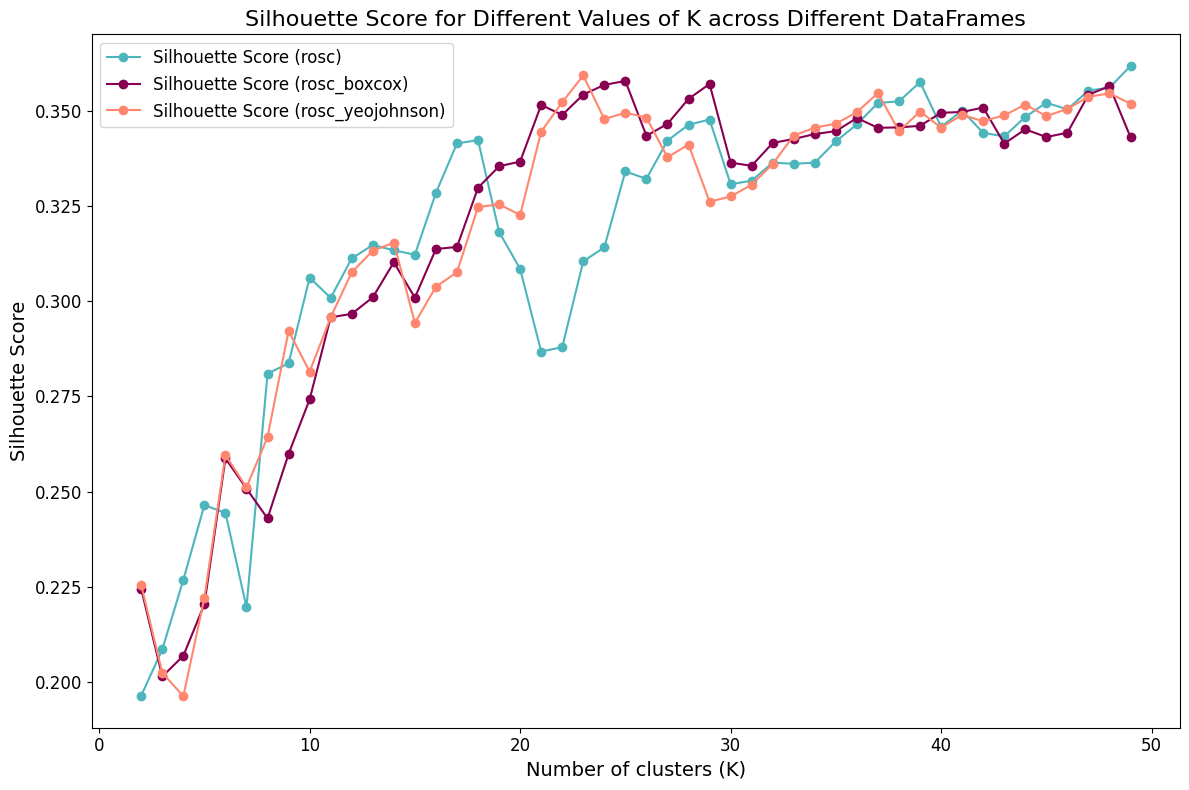

In [12]:
# Define Karolinska Institutet colors for the lines
KI_COLORS = {
    "dataframe1": "#4DB5BC",  # Blue
    "dataframe2": "#870052",  # Plum
    "dataframe3": "#FF876F",  # Orange
    "dataframe4": "#C7ECDC",  # Light Green
    "dataframe5": "#F59A00",  # Dark Yellow
    # Add more colors here if more dataframes are used
}

# Decide the number of k
# Initialize lists to hold values for plotting
silhouette_scores_all = {key: [] for key in dataframes_clustering.keys()}
k_values = range(2, 50)

# Iterate over each dataframe and calculate silhouette scores
for name, data in dataframes_clustering.items():
    print(f"Calculating silhouette scores for {name}...")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=2023)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores_all[name].append(silhouette_avg)
        print(f"For {name}, n_clusters = {k}, the average silhouette score is: {silhouette_avg}")

# Plot silhouette scores for each dataframe
plt.figure(figsize=(12, 8))
for i, (name, scores) in enumerate(silhouette_scores_all.items()):
    color = list(KI_COLORS.values())[i % len(KI_COLORS)]  # Cycle through colors if needed
    plt.plot(k_values, scores, marker='o', label=f'Silhouette Score ({name})', color=color)

# Formatting the plot
plt.xlabel('Number of clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score for Different Values of K across Different DataFrames', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig("graphics/silhouette_scores_transparent.svg", format="svg", transparent=True)  # Save transparent version
plt.savefig("graphics/silhouette_scores_white.svg", format="svg", transparent=False)  # Save white background version

# Show the plot
plt.show()


### 2.2 Calinski-Harabasz Index  

We use the **Calinski-Harabasz Index** (also known as the Variance Ratio Criterion) to evaluate the clustering performance and determine the optimal number of clusters for the `machine_learning_patient_data`. The Calinski-Harabasz index is a ratio of the sum of between-cluster dispersion and within-cluster dispersion, providing a quantitative measure of clustering quality.  

- **Higher values** of the Calinski-Harabasz Index indicate better-defined clusters where data points are tightly grouped within clusters and clearly separated between clusters.  
- This method complements the **Silhouette Scores**, helping validate the cluster selection process with an additional quality measure.  

The algorithm calculates the Calinski-Harabasz index across a range of cluster numbers, typically from **2 to 50 clusters**, similar to our Silhouette Score approach. As mentioned earlier, we aim to identify an optimal balance between well-separated clusters and interpretability in clinical settings.  

**Key considerations**:  
- Focusing on **lower cluster counts** (preferably under 20) ensures interpretability, particularly for identifying patient subgroups.  
- While higher index values at larger cluster counts may indicate better mathematical separation, they can capture noise or lead to overfitting.  
- A **local maximum** under 20 clusters will be prioritized to identify meaningful and clinically relevant groups.  

By comparing the Calinski-Harabasz results to the Silhouette Scores, we aim to achieve consistent insights into the ideal cluster count for subsequent analysis.  


Calculating CHI scores for rosc...
For rosc, n_clusters = 2, the CHI score is: 106.3161370470818
For rosc, n_clusters = 3, the CHI score is: 141.56496502305728
For rosc, n_clusters = 4, the CHI score is: 135.63314508791157
For rosc, n_clusters = 5, the CHI score is: 127.66241015702784
For rosc, n_clusters = 6, the CHI score is: 115.87602546824523
For rosc, n_clusters = 7, the CHI score is: 108.82790286972269
For rosc, n_clusters = 8, the CHI score is: 118.97349879520914
For rosc, n_clusters = 9, the CHI score is: 113.95900742446
For rosc, n_clusters = 10, the CHI score is: 116.15940675254372
For rosc, n_clusters = 11, the CHI score is: 108.97075634531431
For rosc, n_clusters = 12, the CHI score is: 112.14739316451262
For rosc, n_clusters = 13, the CHI score is: 110.50792679558704
For rosc, n_clusters = 14, the CHI score is: 103.6911911046231
For rosc, n_clusters = 15, the CHI score is: 98.71078449974593
For rosc, n_clusters = 16, the CHI score is: 99.69621965998914
For rosc, n_clusters

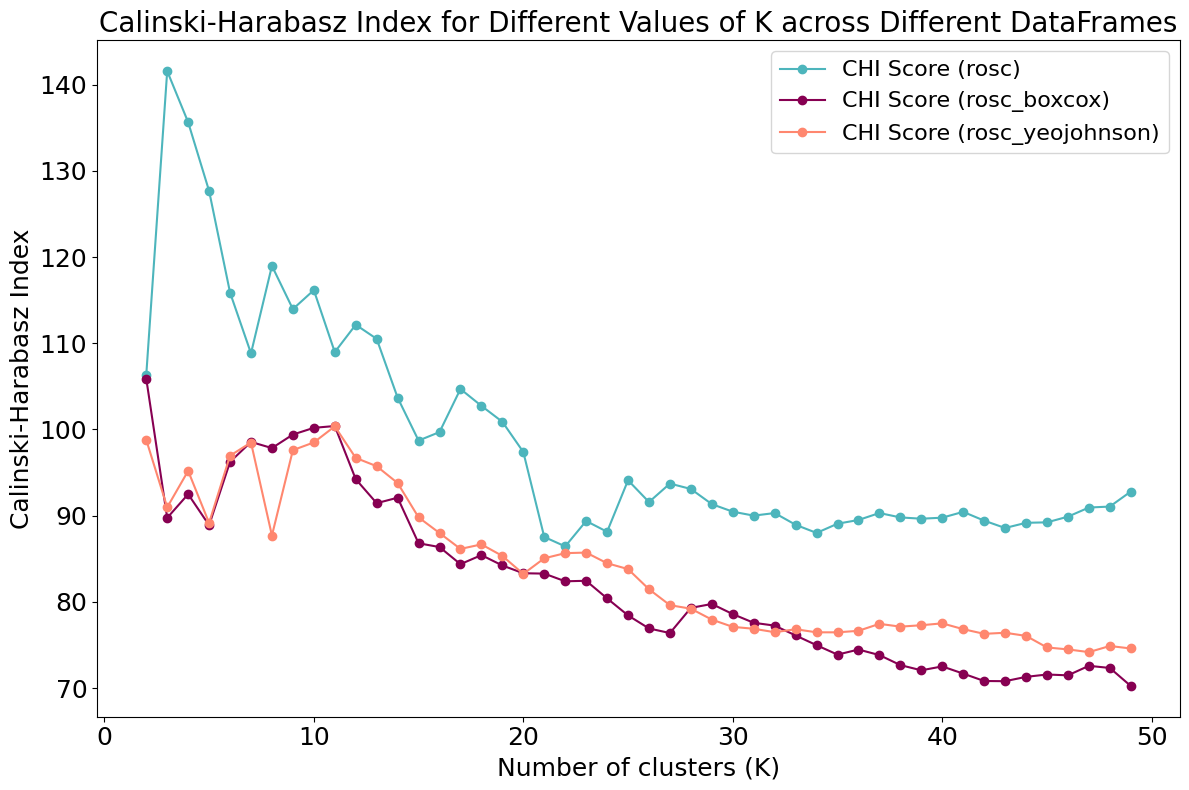

In [13]:
from sklearn.metrics import calinski_harabasz_score

# Define Karolinska Institutet colors for the lines
KI_COLORS = {
    "dataframe1": "#4DB5BC",  # Blue
    "dataframe2": "#870052",  # Plum
    "dataframe3": "#FF876F",  # Orange
    "dataframe4": "#C7ECDC",  # Light Green
    "dataframe5": "#F59A00",  # Dark Yellow
    # Add more colors here if more dataframes are used
}

# Font sizes for the plot
font_size = 20
axis_font_size = 18
legend_font_size = 16

# Initialize lists to hold values for plotting
chi_scores_all = {key: [] for key in dataframes_clustering.keys()}
k_values = range(2, 50)

# Iterate over each dataframe and calculate CHI scores
for name, data in dataframes_clustering.items():
    print(f"Calculating CHI scores for {name}...")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=2023)
        cluster_labels = kmeans.fit_predict(data)
        chi_score = calinski_harabasz_score(data, cluster_labels)
        chi_scores_all[name].append(chi_score)
        print(f"For {name}, n_clusters = {k}, the CHI score is: {chi_score}")

# Plot CHI scores for each dataframe
plt.figure(figsize=(12, 8))
for i, (name, scores) in enumerate(chi_scores_all.items()):
    color = list(KI_COLORS.values())[i % len(KI_COLORS)]  # Cycle through colors if needed
    plt.plot(k_values, scores, marker='o', label=f'CHI Score ({name})', color=color)

# Formatting the plot
plt.xlabel('Number of clusters (K)', fontsize=axis_font_size)
plt.ylabel('Calinski-Harabasz Index', fontsize=axis_font_size)
plt.title('Calinski-Harabasz Index for Different Values of K across Different DataFrames', fontsize=font_size)
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)
plt.legend(fontsize=legend_font_size, loc="best")
plt.tight_layout()

# Save the plot
plt.savefig("graphics/chi_scores_transparent.svg", format="svg", transparent=True)  # Save transparent version
plt.savefig("graphics/chi_scores_white.svg", format="svg", transparent=False)  # Save white background version

# Show the plot
plt.show()


### Evaluation of Silhouette Scores for KMeans Clustering

The silhouette scores for different values of \( K \) (number of clusters) and various scaling approaches provide insights into the optimal clustering structure:

- **Rosc_yeojohnson** reaches its highest silhouette score of approximately **0.359** at \( K = 23 \), indicating a potential for more nuanced clustering with this transformation.
- **Standardized rosc** shows the highest silhouette scores for smaller clusters **0.306** at \( K = 10 \).

For scenarios favoring a lower number of clusters, we focus on **standardized rosc** scores for interpretability.

### 2.3 Visualization of Clusters  

To better understand the identified clusters, we visualize the results in both **3D** and **2D** spaces using **Principal Component Analysis (PCA)** for dimensionality reduction. This visualization helps illustrate the separation and distribution of clusters in a simplified manner, making it easier to interpret the clustering results.

---

#### **3D Visualization**  

We reduce the data to **3 components** using PCA and apply **K-Means clustering** with **4 and 10 clusters**. Each cluster is represented by different colors, with centroids highlighted in red for clear visibility.

- **4 clusters**: Highlights broad groupings of the data.  
- **10 clusters**: Provides a more detailed view of smaller subgroups.  

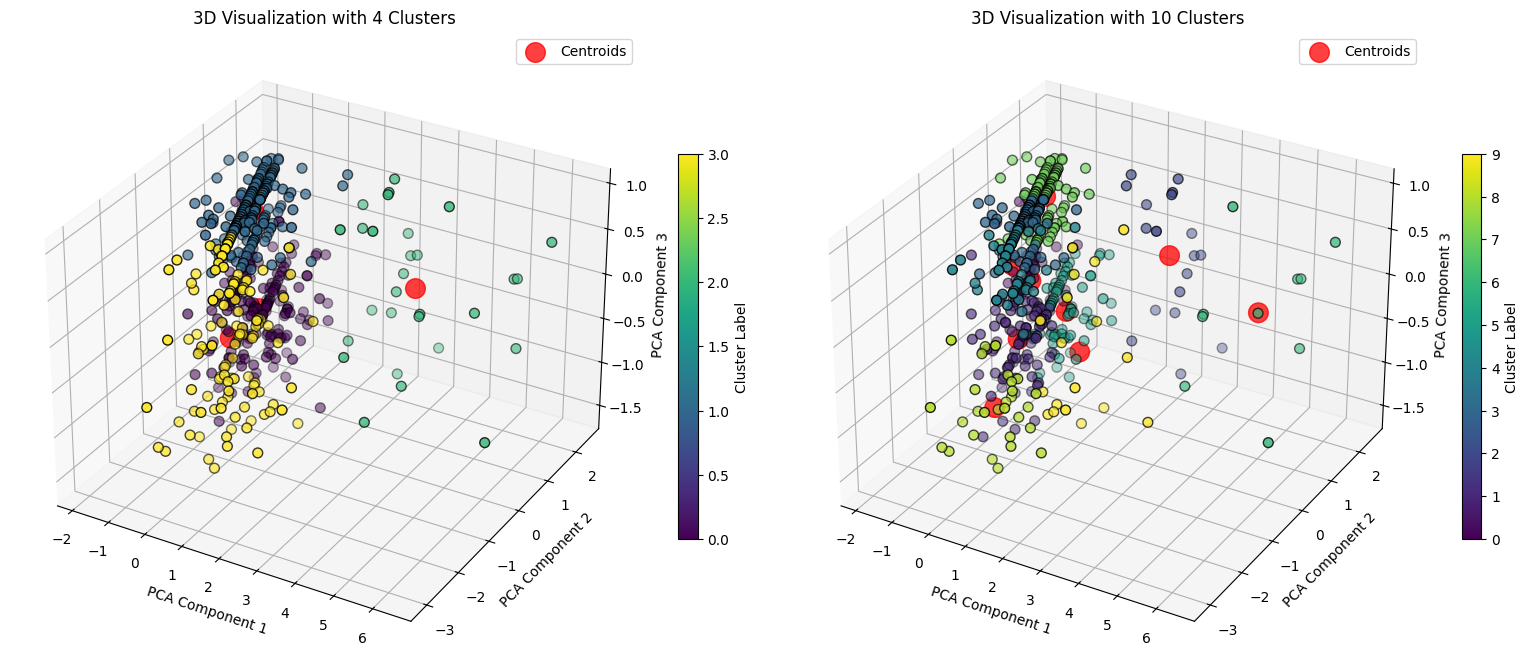

In [14]:
# Step 1: Reduce data to 3D using PCA
pca = PCA(n_components=3)
data_3d = pca.fit_transform(dataframes_clustering['rosc'])

# Step 2: Fit K-Means for 4 and 10 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=2024)
labels_4 = kmeans_4.fit_predict(data_3d)

kmeans_10 = KMeans(n_clusters=10, random_state=2024)
labels_10 = kmeans_10.fit_predict(data_3d)

# Step 3: Create subplots for 4 and 10 clusters
fig = plt.figure(figsize=(16, 8))

# Subplot for 4 clusters
ax1 = fig.add_subplot(121, projection='3d')
scatter_4 = ax1.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2],
                        c=labels_4, cmap='viridis', s=50, edgecolor='k')
ax1.scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[:, 1], kmeans_4.cluster_centers_[:, 2],
            c='red', s=200, alpha=0.75, label='Centroids')
ax1.set_title('3D Visualization with 4 Clusters')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.legend()
fig.colorbar(scatter_4, ax=ax1, shrink=0.5, label='Cluster Label')

# Subplot for 10 clusters
ax2 = fig.add_subplot(122, projection='3d')
scatter_10 = ax2.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2],
                         c=labels_10, cmap='viridis', s=50, edgecolor='k')
ax2.scatter(kmeans_10.cluster_centers_[:, 0], kmeans_10.cluster_centers_[:, 1], kmeans_10.cluster_centers_[:, 2],
            c='red', s=200, alpha=0.75, label='Centroids')
ax2.set_title('3D Visualization with 10 Clusters')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.legend()
fig.colorbar(scatter_10, ax=ax2, shrink=0.5, label='Cluster Label')

plt.tight_layout()
plt.show()

#### **2D Visualization**
For simpler visualization, the data is reduced to 2 components using PCA, and the same K-Means clustering approach is applied for 4 and 10 clusters. This view offers a flat representation of the cluster separations.

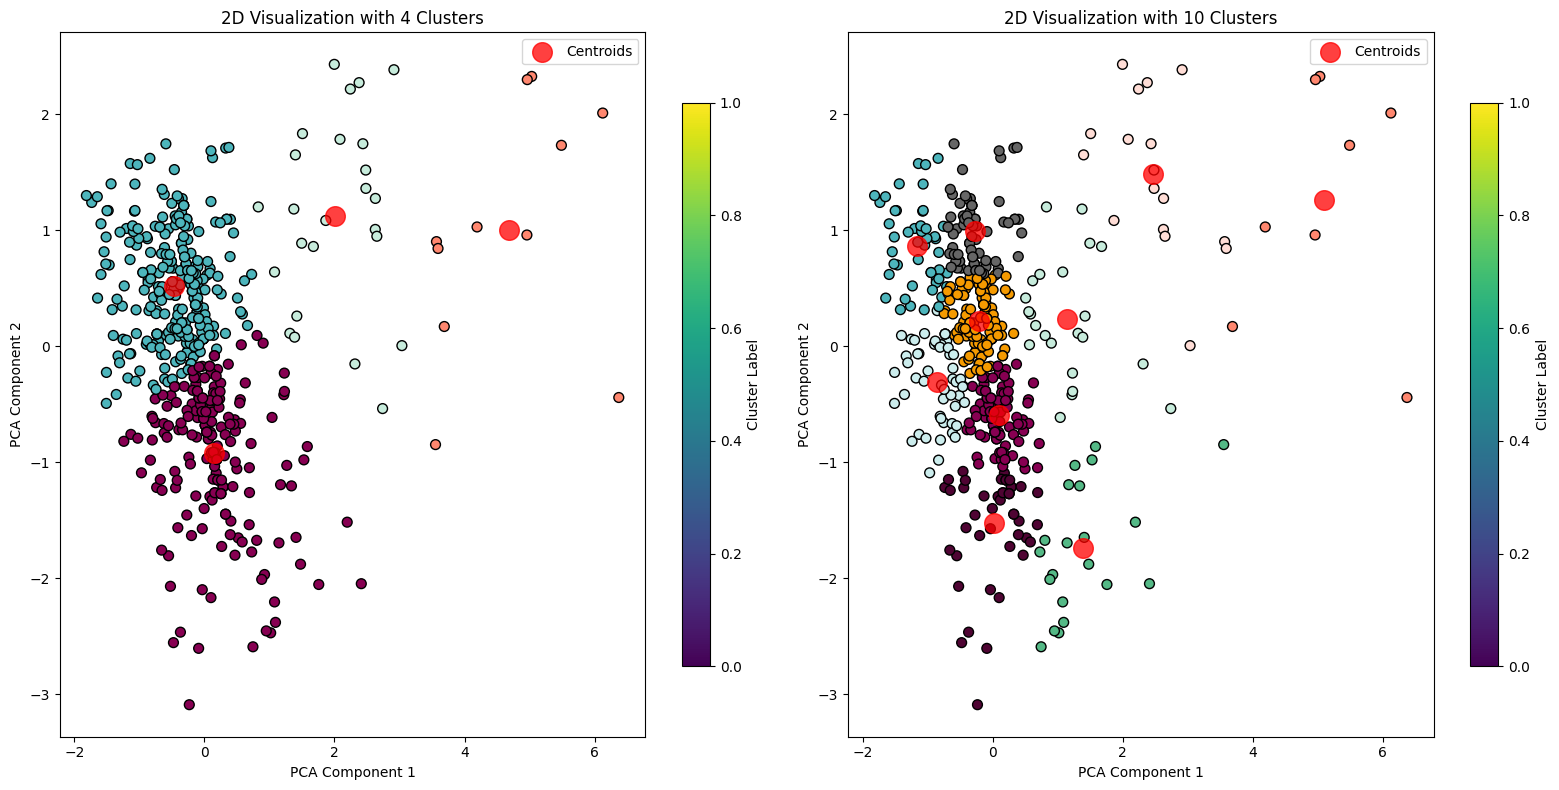

In [15]:
# Step 1: Reduce data to 2D using PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(dataframes_clustering['rosc'])

# Step 2: Fit K-Means for 4 and 10 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=2024)
labels_4 = kmeans_4.fit_predict(data_2d)

kmeans_10 = KMeans(n_clusters=10, random_state=2024)
labels_10 = kmeans_10.fit_predict(data_2d)

# Define Karolinska Institutet colors for clusters
KI_COLORS = {
    0: "#4DB5BC",  # Blue
    1: "#870052",  # Plum
    2: "#FF876F",  # Orange
    3: "#C7ECDC",  # Light Green
    4: "#F59A00",  # Dark Yellow
    5: "#4F0433",  # Dark Plum
    6: "#FFDDD6",  # Light Orange
    7: "#666666",  # Grey
    8: "#CCEDED",  # Light Blue
    9: "#54B986"   # Green
}

# Generate color maps for clusters
color_map_4 = [KI_COLORS[label] for label in labels_4]
color_map_10 = [KI_COLORS[label % len(KI_COLORS)] for label in labels_10]  # Cycle through colors if >10 clusters

# Step 3: Create subplots for 4 and 10 clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Subplot for 4 clusters
ax1 = axes[0]
scatter_4 = ax1.scatter(data_2d[:, 0], data_2d[:, 1],
                        c=color_map_4, s=50, edgecolor='k')
ax1.scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[:, 1],
            c='red', s=200, alpha=0.75, label='Centroids')
ax1.set_title('2D Visualization with 4 Clusters')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.legend()
fig.colorbar(scatter_4, ax=ax1, shrink=0.8, label='Cluster Label')

# Subplot for 10 clusters
ax2 = axes[1]
scatter_10 = ax2.scatter(data_2d[:, 0], data_2d[:, 1],
                         c=color_map_10, s=50, edgecolor='k')
ax2.scatter(kmeans_10.cluster_centers_[:, 0], kmeans_10.cluster_centers_[:, 1],
            c='red', s=200, alpha=0.75, label='Centroids')
ax2.set_title('2D Visualization with 10 Clusters')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.legend()
fig.colorbar(scatter_10, ax=ax2, shrink=0.8, label='Cluster Label')

plt.tight_layout()
plt.show()


#### Saving Data for Classification Attempts

We are saving `machine_learning_df` to use consistently across classification attempts, ensuring that the same data preparation is applied throughout the model evaluation process.


In [16]:
# Select the data for clustering
data_for_clustering = machine_learning_df.drop(columns=['rosc_boxcox', 'rosc_yeojohnson'])
data_for_clustering

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,False,True,False,False,True,False,-0.215362
2,296,-0.842797,False,True,True,False,False,False,True,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,False,True,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,False,True,False,False,True,False,0.225655
5,306,0.757250,False,True,True,False,False,True,False,True,False,False,-0.068356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,1015,0.117231,True,False,False,False,True,False,True,False,False,True,-0.435870
602,1016,1.653275,False,True,True,False,False,True,False,True,False,False,-1.023892
604,1018,0.117231,False,True,True,False,False,False,True,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,False,True,False,True,False,-0.215362


In [17]:
# Save the DataFrame to a Pickle file
with open('data/machine_learning_patient_data.pkl', 'wb') as f:
    pickle.dump(data_for_clustering, f)

# Confirmation message
print("DataFrame has been saved to 'data/machine_learning_patient_data.pkl'")

DataFrame has been saved to 'data/machine_learning_patient_data.pkl'


### Perform the Clustering  

In this section, we apply the **K-Means clustering** to identify groups of patients with shared characteristics with the previously identified number of clusters. The clustering process aims to evaluate whether distinct subgroups exist that exhibit meaningful differences in their outcomes or responses to TTM protocols.  

We will **Analyze feature distributions** across the identified clusters to evaluate differences and similarities.  

This analysis helps us explore potential subpopulations that might benefit (or be harmed) by specific TTM strategies, laying the foundation for further predictive modeling and counterfactual analysis.  


In [18]:
# Drop patient number before clustering
data_for_clustering = data_for_clustering.drop('Patient', axis=1)

# Perform K-means clustering on the standardized data
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=2023)
kmeans.fit(data_for_clustering)

# Add cluster labels from KMeans to the original data as 'kmeans_cluster'
original_data['kmeans_cluster'] = kmeans.labels_

# Display the first few rows of processed_data with the cluster labels
original_data.head()


,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing,kmeans_cluster
0,284,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0,3
2,296,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0,3
3,299,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0,3
4,303,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0,3
5,306,E,73.0,Male,20.0,True,False,33.0,Good,1,0,0,6


In [19]:
# Count the number of data points in each cluster
cluster_counts = original_data['kmeans_cluster'].value_counts()

# Display the counts for each cluster
print(cluster_counts)

kmeans_cluster
0    88
3    83
6    73
9    53
4    48
7    39
1    36
8    35
2    27
5    27
Name: count, dtype: int64


#### 2.2 Cluster Analysis

We will now analyze the clusters by examining the distribution of features within each cluster. This analysis will provide insights into the characteristics that define each group.


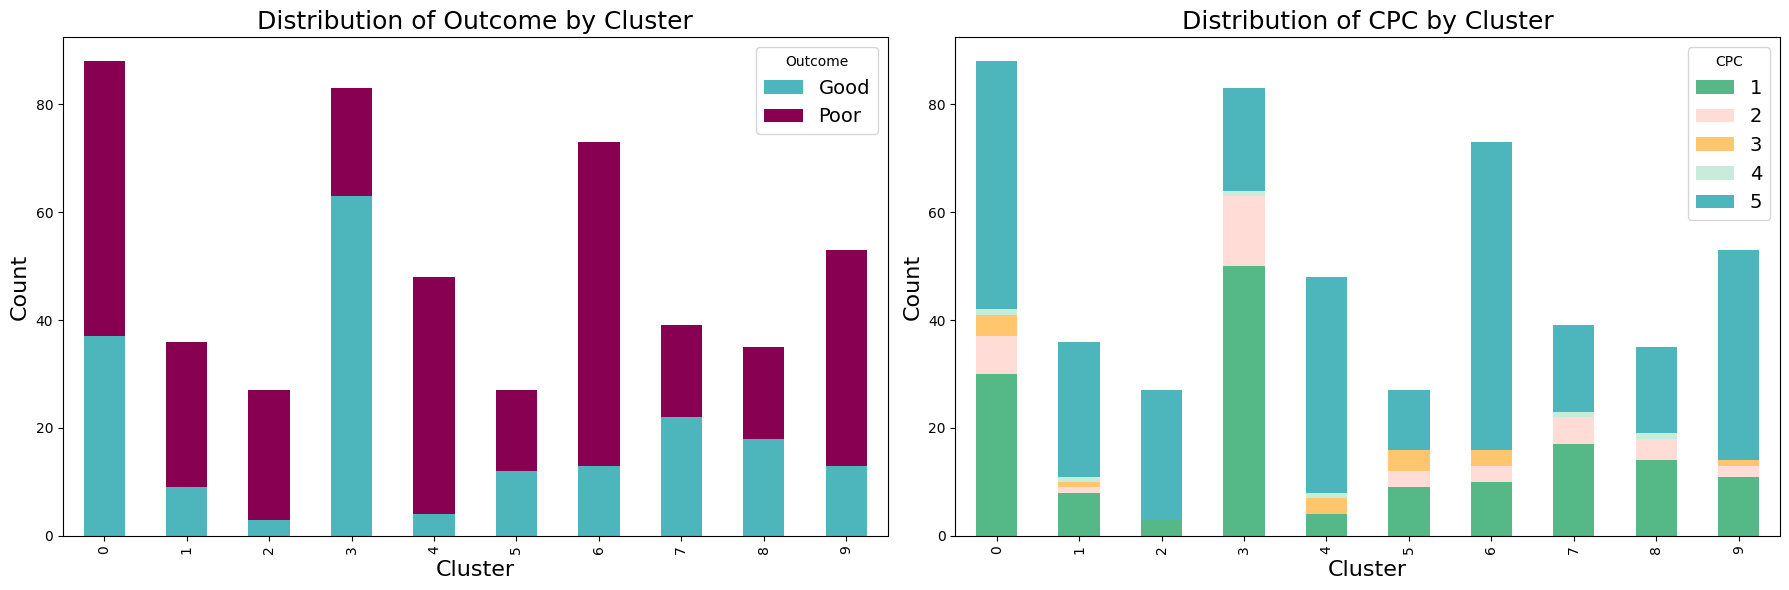

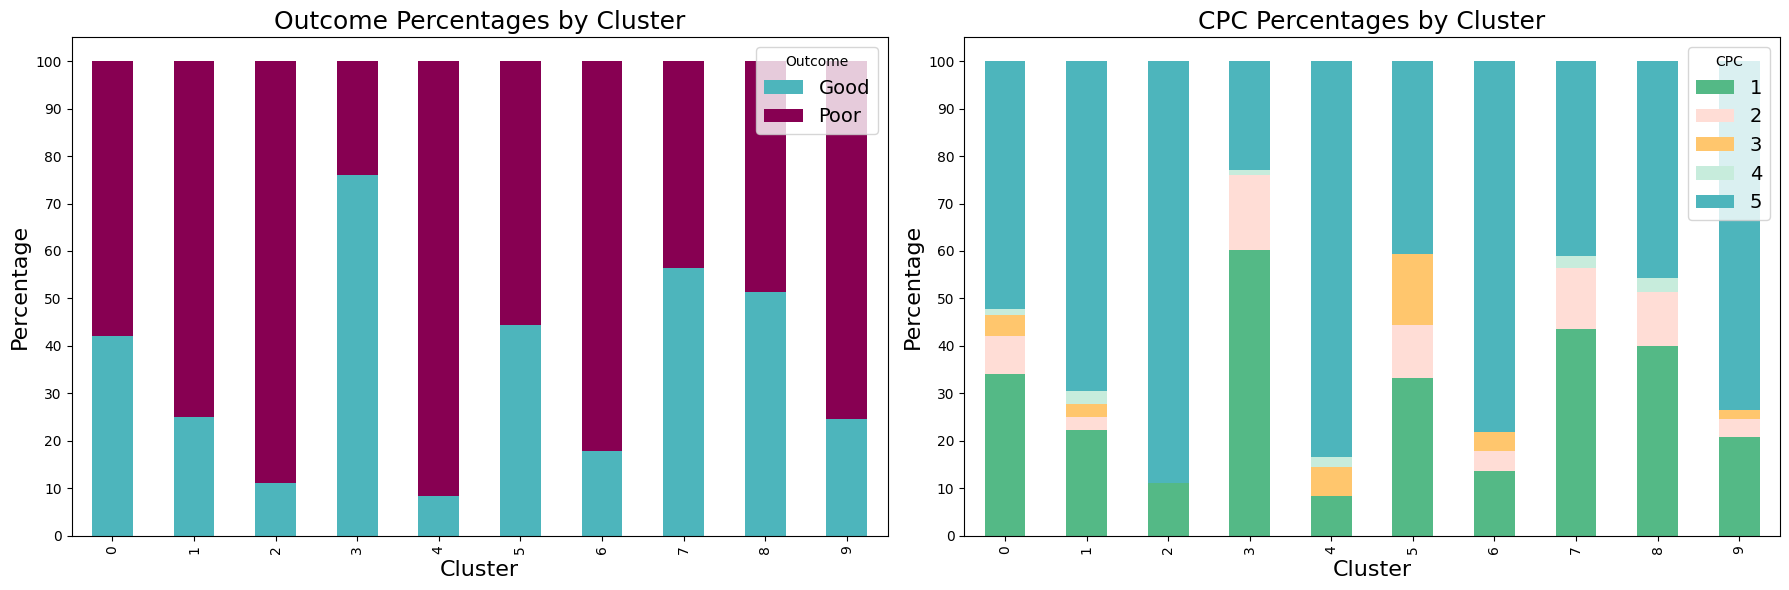

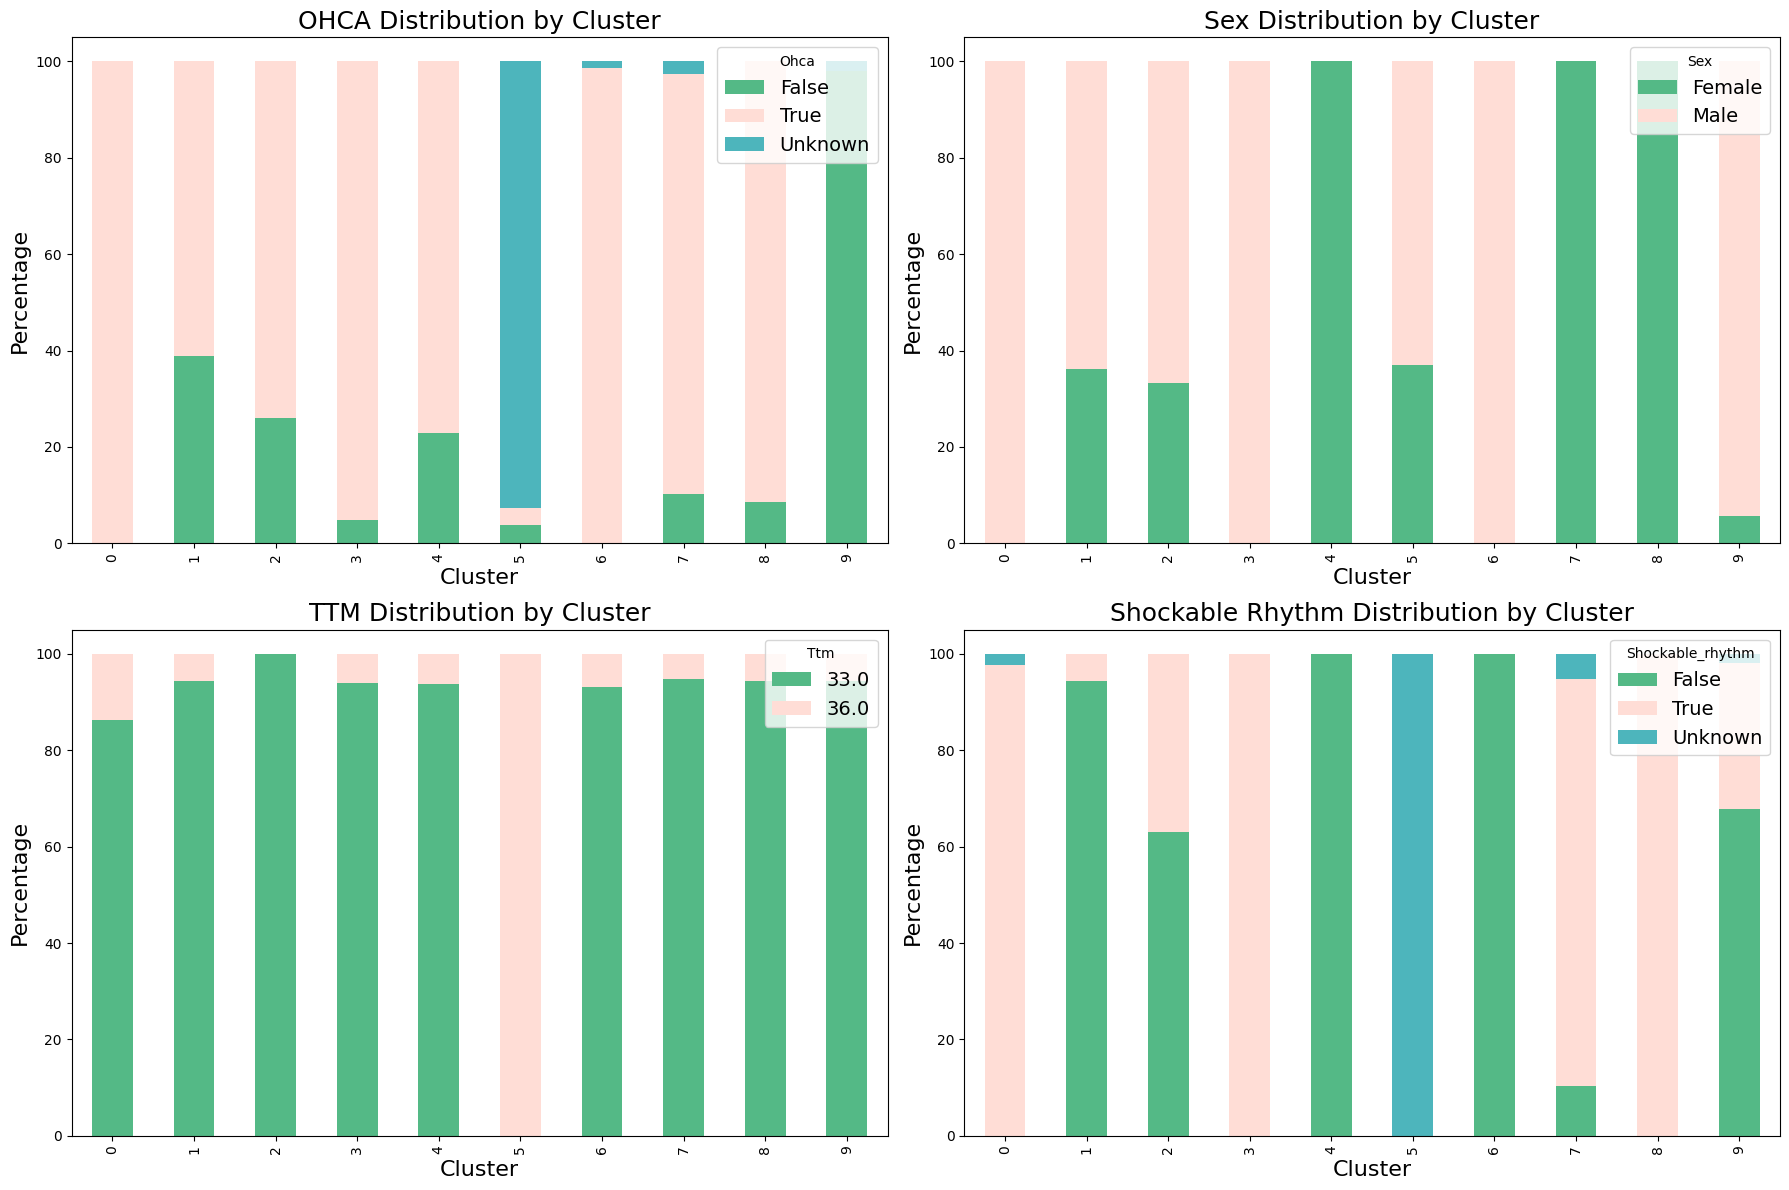

C:\Users\kentf\AppData\Local\Temp\ipykernel_14656\2008930851.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="kmeans_cluster", y=feature, data=original_data, ax=ax, palette=feature_colors[:original_data['kmeans_cluster'].nunique()])
C:\Users\kentf\AppData\Local\Temp\ipykernel_14656\2008930851.py:127: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="kmeans_cluster", y=feature, data=original_data, ax=ax, palette=feature_colors[:original_data['kmeans_cluster'].nunique()])
C:\Users\kentf\AppData\Local\Temp\ipykernel_14656\2008930851.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="km

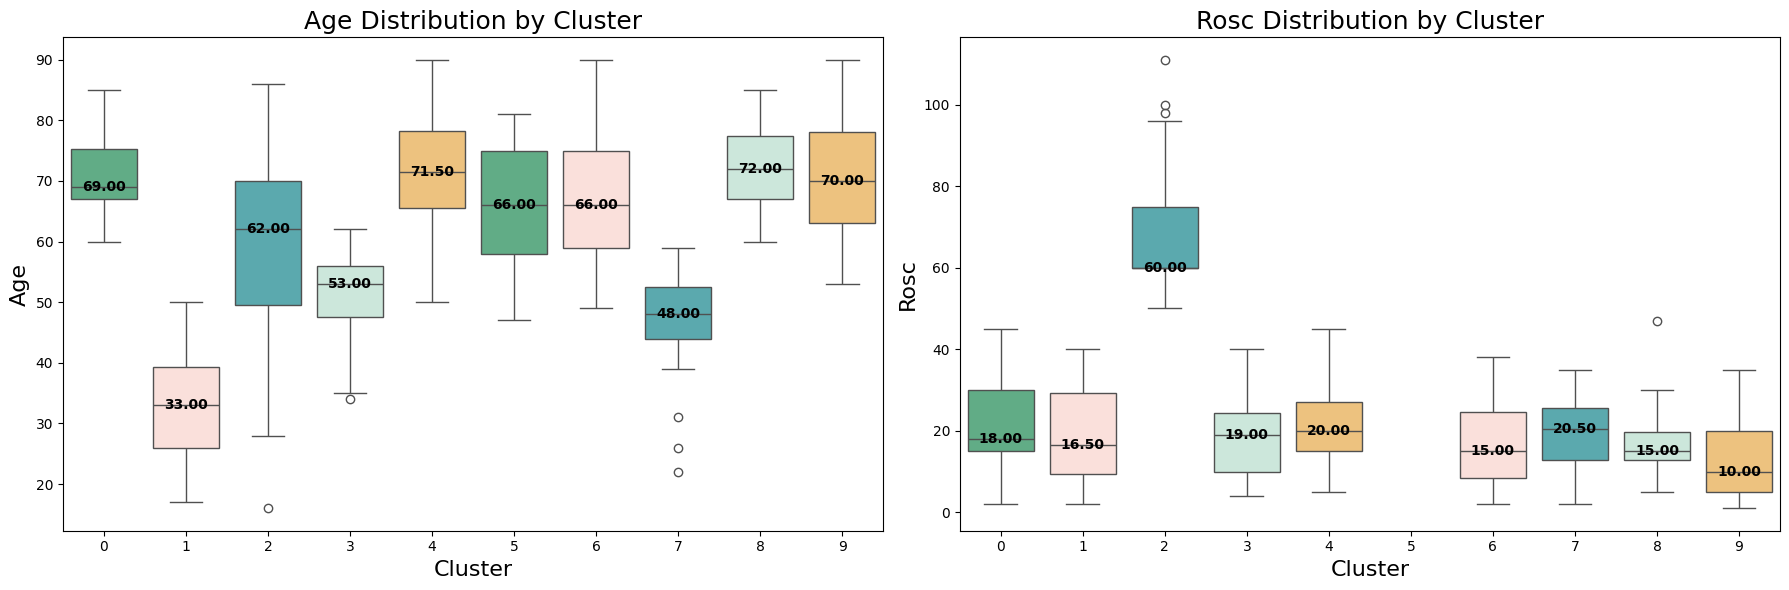

In [20]:
# Define KI color scheme with unique colors
KI_COLORS = {
    "dark_plum": "#4F0433",
    "orange": "#FF876F",
    "plum": "#870052",
    "light_orange": "#FFDDD6",
    "blue": "#4DB5BC",
    "light_blue": "#CCEBED",
    "green": "#54B986",
    "light_green": "#C7ECDC",
    "yellow": "#FFC66D",
    "light_yellow": "#FFE7C2",
}

# Adjust font sizes
title_font_size = 18
axis_font_size = 16
legend_font_size = 14

# Colors for CPC categories
cpc_colors = [
    KI_COLORS["green"],
    KI_COLORS["light_orange"],
    KI_COLORS["yellow"],
    KI_COLORS["light_green"],
    KI_COLORS["blue"],
]

# Colors for Outcome categories
outcome_colors = [KI_COLORS["blue"], KI_COLORS["plum"]]

# ----------------- CPC and Outcome Distribution -----------------
# Count the occurrences of each CPC value for each cluster
cpc_counts = original_data.groupby(['kmeans_cluster', 'cpc'], observed=True).size().unstack(fill_value=0)

# Count the occurrences of each Outcome value for each cluster
outcome_counts = original_data.groupby(['kmeans_cluster', 'outcome'], observed=True).size().unstack(fill_value=0)

# Create a figure with 2 subplots for CPC and Outcome distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Outcome distribution
outcome_counts.plot(kind="bar", stacked=True, ax=axes[0], color=outcome_colors)
axes[0].set_title("Distribution of Outcome by Cluster", fontsize=title_font_size)
axes[0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0].set_ylabel("Count", fontsize=axis_font_size)
axes[0].legend(title="Outcome", fontsize=legend_font_size)

# Plot CPC distribution
cpc_counts.plot(kind="bar", stacked=True, ax=axes[1], color=cpc_colors)
axes[1].set_title("Distribution of CPC by Cluster", fontsize=title_font_size)
axes[1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1].set_ylabel("Count", fontsize=axis_font_size)
axes[1].legend(title="CPC", fontsize=legend_font_size)

plt.tight_layout()
plt.show()

# ----------------- Percentages by Cluster -----------------
# Calculate percentages for Outcome and CPC
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
cpc_percentages = cpc_counts.div(cpc_counts.sum(axis=1), axis=0) * 100

# Create side-by-side bar plots for percentages
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Outcome percentages
outcome_percentages.plot(kind="bar", stacked=True, ax=axes[0], color=outcome_colors)
axes[0].set_title("Outcome Percentages by Cluster", fontsize=title_font_size)
axes[0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0].set_ylabel("Percentage", fontsize=axis_font_size)
axes[0].legend(title="Outcome", fontsize=legend_font_size)
axes[0].set_yticks(range(0, 101, 10))

# Plot CPC percentages
cpc_percentages.plot(kind="bar", stacked=True, ax=axes[1], color=cpc_colors)
axes[1].set_title("CPC Percentages by Cluster", fontsize=title_font_size)
axes[1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1].set_ylabel("Percentage", fontsize=axis_font_size)
axes[1].legend(title="CPC", fontsize=legend_font_size)
axes[1].set_yticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

# ----------------- Categorical Feature Distributions -----------------
categorical_features_list = [
    ("ohca", "OHCA Distribution by Cluster"),
    ("sex", "Sex Distribution by Cluster"),
    ("ttm", "TTM Distribution by Cluster"),
    ("shockable_rhythm", "Shockable Rhythm Distribution by Cluster"),
]

# Set up a 2x2 grid for categorical features
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Adjust size for all features
axes = axes.flatten()  # Flatten for easier indexing

# Assign distinct colors for categorical features
feature_colors = [
    KI_COLORS["green"],
    KI_COLORS["light_orange"],
    KI_COLORS["blue"],
    KI_COLORS["light_green"],
    KI_COLORS["yellow"],
]

# Loop through each feature and create a plot
for ax, (feature, title) in zip(axes, categorical_features_list):
    feature_counts = original_data.groupby(['kmeans_cluster', feature], observed=True).size().unstack(fill_value=0)
    feature_percentages = feature_counts.div(feature_counts.sum(axis=1), axis=0) * 100

    feature_percentages.plot(kind="bar", stacked=True, ax=ax, color=feature_colors[:feature_percentages.shape[1]])
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlabel("Cluster", fontsize=axis_font_size)
    ax.set_ylabel("Percentage", fontsize=axis_font_size)
    ax.legend(title=feature.capitalize(), fontsize=legend_font_size, loc="upper right")

plt.tight_layout()
plt.show()

# ----------------- Numeric Feature Boxplots -----------------
numeric_features = ["age", "rosc"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Create box plots for numeric features
for ax, feature in zip(axes, numeric_features):
    sns.boxplot(x="kmeans_cluster", y=feature, data=original_data, ax=ax, palette=feature_colors[:original_data['kmeans_cluster'].nunique()])
    ax.set_title(f"{feature.capitalize()} Distribution by Cluster", fontsize=title_font_size)
    ax.set_xlabel("Cluster", fontsize=axis_font_size)
    ax.set_ylabel(feature.capitalize(), fontsize=axis_font_size)

    # Annotate medians
    medians = original_data.groupby("kmeans_cluster")[feature].median()
    for cluster, median_val in medians.items():
        ax.text(cluster, median_val, f"{median_val:.2f}", ha="center", va="center", color="black", fontweight="bold")

plt.tight_layout()
plt.show()


C:\Users\kentf\AppData\Local\Temp\ipykernel_14656\338880576.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


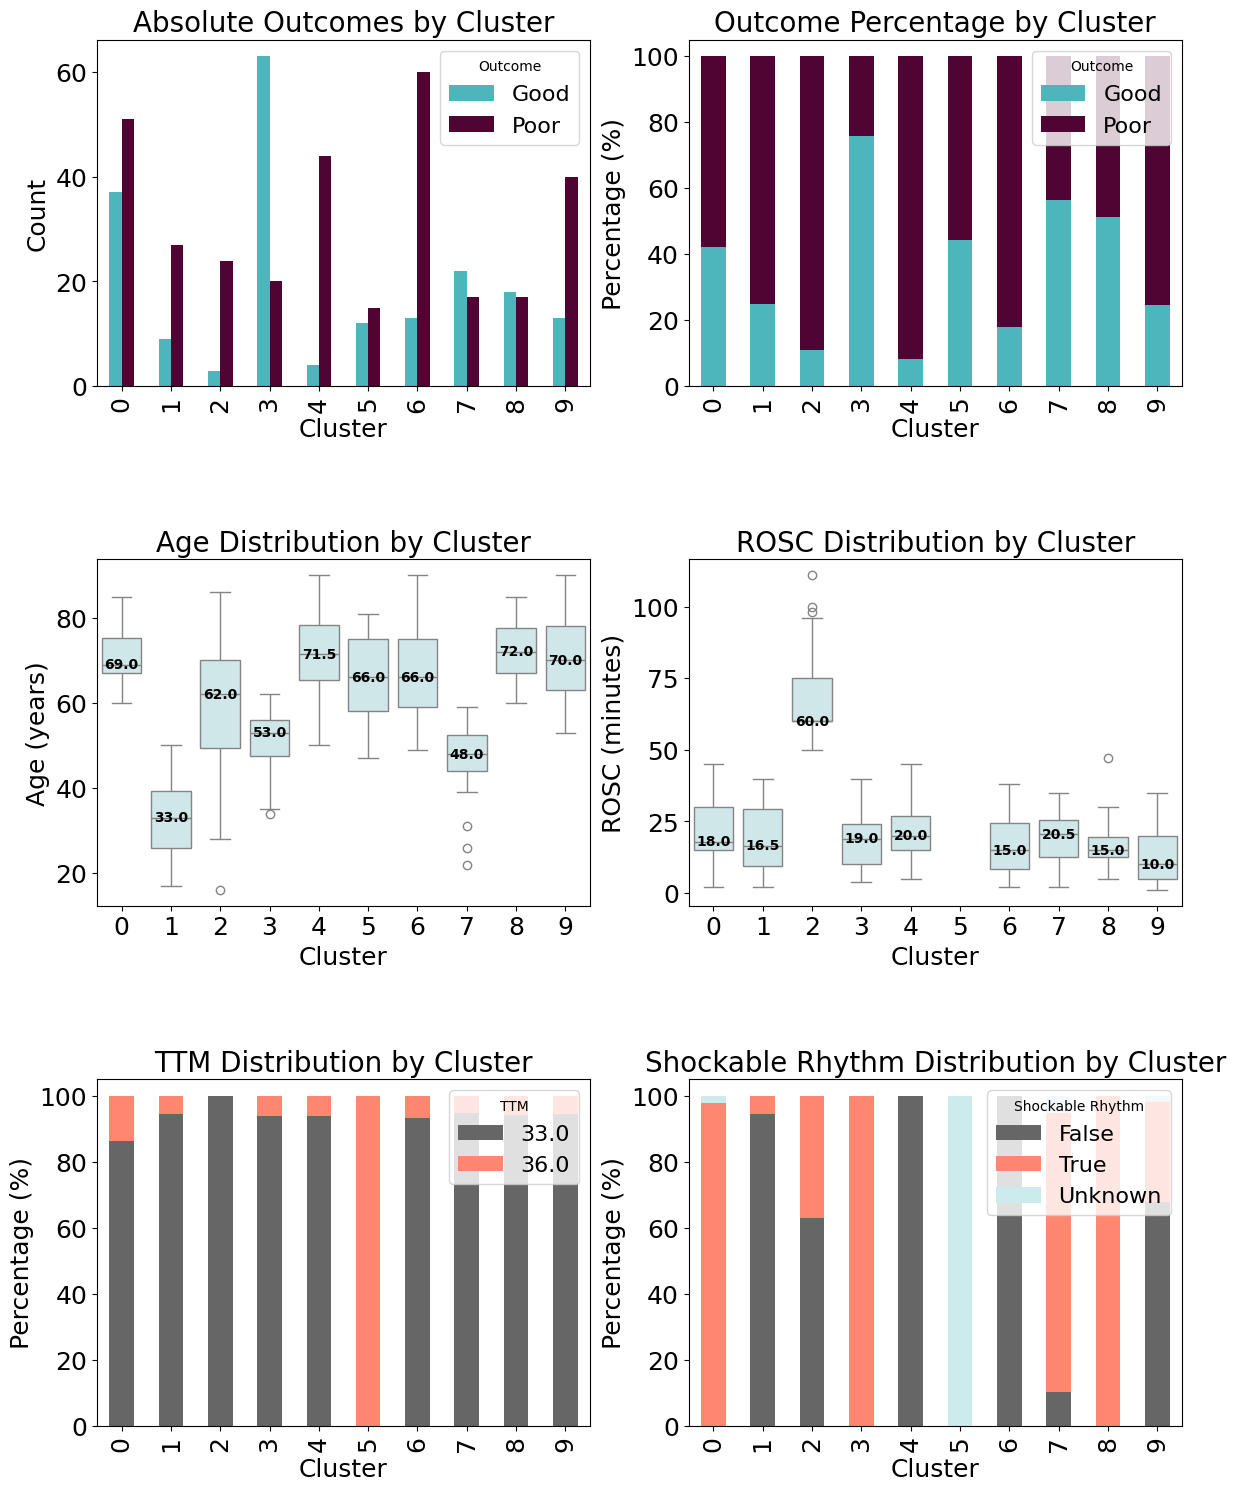

In [21]:
# Define font sizes
font_size = 20
axis_font_size = 18
legend_font_size = 16

# Updated dictionary of colors
KI_COLORS_UPDATED = {
    "blue": "#4DB5BC",          # Outcome: Good
    "plum": "#4F0433",          # Outcome: Poor
    "lightblue": "#CCEBED",     # Boxplots
    "orange": "#FF876F",        # TTM: 36
    "dark_plum": "#666666",     # TTM: 33
    "lightorange": "#FFDDD6",   # TTM: Unknown
}

# Set up figure and axes for 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(14, 18), gridspec_kw={'hspace': 0.5})  # Adjusted spacing

# 1st Row, 1st Col: Absolute number of Good and Poor Outcomes by Cluster
outcome_counts = original_data.groupby(['kmeans_cluster', 'outcome'], observed=True).size().unstack(fill_value=0)
outcome_counts.plot(
    kind='bar', 
    stacked=False, 
    ax=axes[0, 0], 
    color=[KI_COLORS_UPDATED['blue'], KI_COLORS_UPDATED['plum']]
)
axes[0, 0].set_title("Absolute Outcomes by Cluster", fontsize=font_size)
axes[0, 0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0, 0].set_ylabel("Count", fontsize=axis_font_size)
axes[0, 0].legend(title="Outcome", fontsize=legend_font_size, loc="upper right")
axes[0, 0].tick_params(axis='both', labelsize=axis_font_size)

# 1st Row, 2nd Col: Outcome Percentage by Cluster
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
outcome_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0, 1], 
    color=[KI_COLORS_UPDATED['blue'], KI_COLORS_UPDATED['plum']]
)
axes[0, 1].set_title("Outcome Percentage by Cluster", fontsize=font_size)
axes[0, 1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0, 1].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[0, 1].legend(title="Outcome", fontsize=legend_font_size, loc="upper right")
axes[0, 1].tick_params(axis='both', labelsize=axis_font_size)

# 2nd Row, 1st Col: Age Distribution by Cluster (Boxplot)
sns.boxplot(
    x='kmeans_cluster', 
    y='age', 
    data=original_data, 
    ax=axes[1, 0], 
    color=KI_COLORS_UPDATED['lightblue']
)
axes[1, 0].set_title("Age Distribution by Cluster", fontsize=font_size)
axes[1, 0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1, 0].set_ylabel("Age (years)", fontsize=axis_font_size)
axes[1, 0].tick_params(axis='both', labelsize=axis_font_size)

# Annotate median values for Age
medians_age = original_data.groupby('kmeans_cluster')['age'].median()
for cluster in medians_age.index:
    median_val = medians_age[cluster]
    axes[1, 0].text(cluster, median_val, f'{median_val:.1f}', 
                    ha='center', va='center', color='black', fontweight='bold')

# 2nd Row, 2nd Col: ROSC Distribution by Cluster (Boxplot)
sns.boxplot(
    x='kmeans_cluster', 
    y='rosc', 
    data=original_data, 
    ax=axes[1, 1], 
    color=KI_COLORS_UPDATED['lightblue']
)
axes[1, 1].set_title("ROSC Distribution by Cluster", fontsize=font_size)
axes[1, 1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1, 1].set_ylabel("ROSC (minutes)", fontsize=axis_font_size)
axes[1, 1].tick_params(axis='both', labelsize=axis_font_size)

# Annotate median values for ROSC
medians_rosc = original_data.groupby('kmeans_cluster')['rosc'].median()
for cluster in medians_rosc.index:
    median_val = medians_rosc[cluster]
    axes[1, 1].text(cluster, median_val, f'{median_val:.1f}', 
                    ha='center', va='center', color='black', fontweight='bold')

# 3rd Row, 1st Col: TTM Distribution by Cluster
ttm_counts = original_data.groupby(['kmeans_cluster', 'ttm'], observed=True).size().unstack(fill_value=0)
ttm_percentages = ttm_counts.div(ttm_counts.sum(axis=1), axis=0) * 100
ttm_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[2, 0], 
    color=[KI_COLORS_UPDATED['dark_plum'], KI_COLORS_UPDATED['orange'], KI_COLORS_UPDATED['lightblue']]
)
axes[2, 0].set_title("TTM Distribution by Cluster", fontsize=font_size)
axes[2, 0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[2, 0].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[2, 0].legend(title="TTM", fontsize=legend_font_size, loc="upper right")
axes[2, 0].tick_params(axis='both', labelsize=axis_font_size)

# 3rd Row, 2nd Col: Shockable Rhythm Distribution by Cluster
shockable_counts = original_data.groupby(['kmeans_cluster', 'shockable_rhythm'], observed=True).size().unstack(fill_value=0)
shockable_percentages = shockable_counts.div(shockable_counts.sum(axis=1), axis=0) * 100
shockable_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[2, 1], 
    color=[KI_COLORS_UPDATED['dark_plum'], KI_COLORS_UPDATED['orange'], KI_COLORS_UPDATED['lightblue']]
)
axes[2, 1].set_title("Shockable Rhythm Distribution by Cluster", fontsize=font_size)
axes[2, 1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[2, 1].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[2, 1].legend(title="Shockable Rhythm", fontsize=legend_font_size, loc="upper right")
axes[2, 1].tick_params(axis='both', labelsize=axis_font_size)

# Adjust layout and save plots
plt.tight_layout()

# Save transparent background version
plt.savefig("comparison_plot_transparent.svg", format="svg", transparent=True)

# Save white background version
plt.savefig("comparison_plot_white.svg", format="svg", transparent=False)

plt.show()


C:\Users\kentf\AppData\Local\Temp\ipykernel_14656\1088981515.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


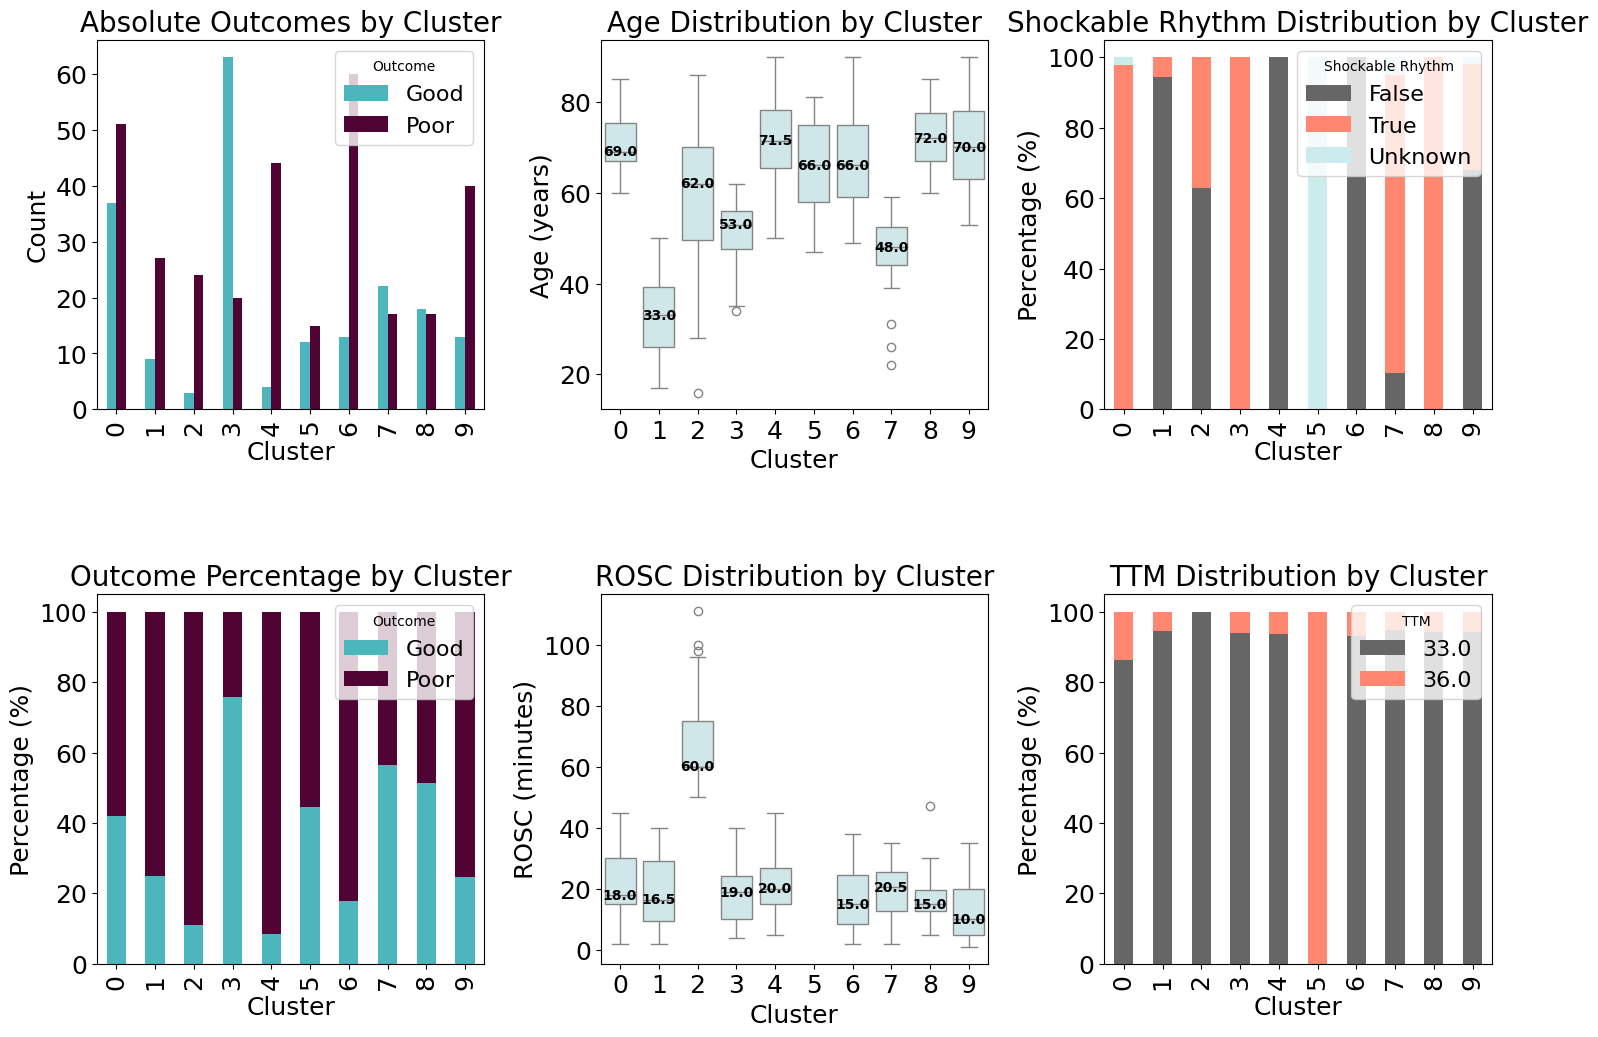

In [23]:
# Define font sizes
font_size = 20
axis_font_size = 18
legend_font_size = 16

# Updated dictionary of colors
KI_COLORS_UPDATED = {
    "blue": "#4DB5BC",          # Outcome: Good
    "plum": "#4F0433",          # Outcome: Poor
    "lightblue": "#CCEBED",     # Boxplots
    "orange": "#FF876F",        # TTM: 36
    "dark_plum": "#666666",     # TTM: 33
    "lightorange": "#FFDDD6",   # TTM: Unknown
}

# Set up figure and axes for 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})  # Adjusted spacing

# 1st Row, 1st Col: Absolute number of Good and Poor Outcomes by Cluster
outcome_counts.plot(
    kind='bar', 
    stacked=False, 
    ax=axes[0, 0], 
    color=[KI_COLORS_UPDATED['blue'], KI_COLORS_UPDATED['plum']]
)
axes[0, 0].set_title("Absolute Outcomes by Cluster", fontsize=font_size)
axes[0, 0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0, 0].set_ylabel("Count", fontsize=axis_font_size)
axes[0, 0].legend(title="Outcome", fontsize=legend_font_size, loc="upper right")
axes[0, 0].tick_params(axis='both', labelsize=axis_font_size)

# 1st Row, 2nd Col: Age Distribution by Cluster (Boxplot)
sns.boxplot(
    x='kmeans_cluster', 
    y='age', 
    data=original_data, 
    ax=axes[0, 1], 
    color=KI_COLORS_UPDATED['lightblue']
)
axes[0, 1].set_title("Age Distribution by Cluster", fontsize=font_size)
axes[0, 1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0, 1].set_ylabel("Age (years)", fontsize=axis_font_size)
axes[0, 1].tick_params(axis='both', labelsize=axis_font_size)

# Annotate median values for Age
medians_age = original_data.groupby('kmeans_cluster')['age'].median()
for cluster in medians_age.index:
    median_val = medians_age[cluster]
    axes[0, 1].text(cluster, median_val, f'{median_val:.1f}', 
                    ha='center', va='center', color='black', fontweight='bold')

# 1st Row, 3rd Col: Shockable Rhythm Distribution by Cluster
shockable_counts = original_data.groupby(['kmeans_cluster', 'shockable_rhythm'], observed=True).size().unstack(fill_value=0)
shockable_percentages = shockable_counts.div(shockable_counts.sum(axis=1), axis=0) * 100
shockable_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0, 2], 
    color=[KI_COLORS_UPDATED['dark_plum'], KI_COLORS_UPDATED['orange'], KI_COLORS_UPDATED['lightblue']]
)
axes[0, 2].set_title("Shockable Rhythm Distribution by Cluster", fontsize=font_size)
axes[0, 2].set_xlabel("Cluster", fontsize=axis_font_size)
axes[0, 2].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[0, 2].legend(title="Shockable Rhythm", fontsize=legend_font_size, loc="upper right")
axes[0, 2].tick_params(axis='both', labelsize=axis_font_size)

# 2nd Row, 1st Col: Outcome Percentage by Cluster
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
outcome_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1, 0], 
    color=[KI_COLORS_UPDATED['blue'], KI_COLORS_UPDATED['plum']]
)
axes[1, 0].set_title("Outcome Percentage by Cluster", fontsize=font_size)
axes[1, 0].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1, 0].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[1, 0].legend(title="Outcome", fontsize=legend_font_size, loc="upper right")
axes[1, 0].tick_params(axis='both', labelsize=axis_font_size)

# 2nd Row, 2nd Col: ROSC Distribution by Cluster (Boxplot)
sns.boxplot(
    x='kmeans_cluster', 
    y='rosc', 
    data=original_data, 
    ax=axes[1, 1], 
    color=KI_COLORS_UPDATED['lightblue']
)
axes[1, 1].set_title("ROSC Distribution by Cluster", fontsize=font_size)
axes[1, 1].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1, 1].set_ylabel("ROSC (minutes)", fontsize=axis_font_size)
axes[1, 1].tick_params(axis='both', labelsize=axis_font_size)

# Annotate median values for ROSC
medians_rosc = original_data.groupby('kmeans_cluster')['rosc'].median()
for cluster in medians_rosc.index:
    median_val = medians_rosc[cluster]
    axes[1, 1].text(cluster, median_val, f'{median_val:.1f}', 
                    ha='center', va='center', color='black', fontweight='bold')

# 2nd Row, 3rd Col: TTM Distribution by Cluster
ttm_counts = original_data.groupby(['kmeans_cluster', 'ttm'], observed=True).size().unstack(fill_value=0)
ttm_percentages = ttm_counts.div(ttm_counts.sum(axis=1), axis=0) * 100
ttm_percentages.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1, 2], 
    color=[KI_COLORS_UPDATED['dark_plum'], KI_COLORS_UPDATED['orange'], KI_COLORS_UPDATED['lightblue']]
)
axes[1, 2].set_title("TTM Distribution by Cluster", fontsize=font_size)
axes[1, 2].set_xlabel("Cluster", fontsize=axis_font_size)
axes[1, 2].set_ylabel("Percentage (%)", fontsize=axis_font_size)
axes[1, 2].legend(title="TTM", fontsize=legend_font_size, loc="upper right")
axes[1, 2].tick_params(axis='both', labelsize=axis_font_size)

# Adjust layout and save plots
plt.tight_layout()

# Save transparent background version
plt.savefig("comparison_plot_wide_transparent.svg", format="svg", transparent=True)

# Save white background version
plt.savefig("comparison_plot_wide_white.svg", format="svg", transparent=False)

plt.show()


## Clustering Result Analysis (same as the presentation)

1. There is no distinct separation between clusters.​

2. Across all clusters, the majority of patients are treated with TTM 33, regardless of whether the outcomes are better or worse.​

3. Clusters with worse outcomes tend to have a higher proportion of patients with unshockable rhythms.​

4. In the cluster with a higher proportion of patients with shockable rhythms but worse outcomes, the mean ROSC time is longer.​

### Conclusion from clustering analysis
Patients with unshockable rhythm and have longer rosc time may not benefit from TTM 33.

### Clustering Result Analysis (including no TTM data points)

The stacked bar plots provide insights into the distribution of outcomes (Good vs. Poor) and CPC (Cerebral Performance Category) scores across different clusters. This visualization can help identify patterns in patient outcomes and neurological performance within each cluster. We are now looking for clusters that have an above average performance and neurological result.

---

#### Outcome Percentages by Cluster
- **Cluster 0**: Shows a mix of Good (blue) and Poor (orange) outcomes, with around 60% good outcomes, indicating a relatively balanced prognosis for this group, which is much higher than for most other clusters.
- **Clusters 1-3**: These clusters have a very high percentage of Poor outcomes, suggesting that they represent patients with worse prognoses and higher associated risks.
- **Cluster 4**: Has a more balanced distribution, with approximately 50% Good and 50% Poor outcomes, indicating a mixed-risk group.
- **Clusters 5, 6, 8**: These clusters are dominated by Bad outcomes, especially Cluster 8, which has nearly all Bad outcomes.
- **Cluster 7**: Has a more balanced distribution of almost 50:50 like **Cluster 4**.

#### CPC Percentages by Cluster
- **Cluster 0**: Shows a substantial proportion of CPC score 1 (blue), but also includes a significant amount of CPC score 5 (purple), indicating a range of neurological outcomes within this cluster.
- **Clusters 1-3**: Predominantly have higher CPC scores, especially CPC score 5 (purple), which is indicative of poorer neurological function or outcomes in these groups. Clusters 1 and 2 have minimal lower CPC scores.
- **Cluster 4**: Shows a similar distribution as **Cluster 0** with a few less CPC score 1 and shifted more towards the higher end of the CPP scale.
- **Clusters 5-8**: Display a broader distribution of CPC scores, with higher concentrations of CPC scores 1-3, suggesting moderate neurological outcomes across these clusters.

---
#### Analysis of the resulting clusters
- **Cluster 0**: Contains the highest proportion of patients with out-of-hospital cardiac arrest, around 90%. This cluster includes only male patients, with nearly 90% receiving TTM at 33°C, some at 36°C, and only a small percentage with no TTM. All patients in this cluster had an initial shockable rhythm. The median age is 64 years, placing it on the younger side among higher-age clusters. The median ROSC time is approximately 16 minutes, positioning it around the middle of clusters with shorter ROSC times.

- **Cluster 4**: Comprises about 80% out-of-hospital cardiac arrests and 20% in-hospital cardiac arrests, consisting only of female patients. Around 80% received TTM at 33°C, a few received TTM at 36°C, and about 15% did not receive TTM. Approximately 70% of the patients had a shockable rhythm. The median age is slightly under 47.5, making it one of the younger clusters. The median ROSC time is around 20 minutes, which is slightly above the median for clusters with shorter ROSC times.

- **Cluster 7**: Primarily has unknown cardiac arrest locations and unknown initial ECG rhythms. All patients in this cluster received TTM at 36°C, and around 35% of the patients were female. The median age is 65.5 years, while the average ROSC time is unknown for these patients.
---

### Overall Insights
- **High-Risk Clusters**: Clusters 0,4, and 7 have a higher proportion of better outcomes compared to the other clusters, with **cluster 0** representing the best results.
- **Few good outcome among many bads**: Many clusters are shifted towards the Bad Outcome area. It might be interesting to understand what differentiates the Good Outcomes among the many Bad Outcomes.